In [80]:
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
import warnings
import seaborn as sns
from sklearn import preprocessing
import matplotlib.pyplot as plt
%matplotlib inline
warnings.filterwarnings('ignore')

df = pd.read_csv('data.csv')
df.drop(["Unnamed: 0","team_id","team_name"], axis=1, inplace=True)
df.head()

,match_event_id,location_x,location_y,remaining_min,power_of_shot,knockout_match,game_season,remaining_sec,distance_of_shot,is_goal,...,shot_id_number,lat/lng,type_of_shot,type_of_combined_shot,match_id,remaining_min.1,power_of_shot.1,knockout_match.1,remaining_sec.1,distance_of_shot.1
0,10.0,167.0,72.0,10.0,1.0,0.0,2000-01,27.0,38.0,NaN,...,1.0,"45.539131, -122.651648",shot - 30,NaN,20000012,10.00,1.0,50.608,54.2000,38.0
1,12.0,-157.0,0.0,10.0,1.0,0.0,2000-01,22.0,35.0,0.0,...,2.0,"45.539131, -122.651648",shot - 45,NaN,20000012,10.00,1.0,28.800,22.0000,35.0
2,35.0,-101.0,135.0,7.0,1.0,0.0,2000-01,45.0,36.0,1.0,...,3.0,"45.539131, -122.651648",shot - 25,NaN,20000012,92.64,1.0,0.000,63.7216,54.4
3,43.0,138.0,175.0,6.0,1.0,0.0,2000-01,52.0,42.0,0.0,...,4.0,"45.539131, -122.651648",NaN,shot - 3,20000012,NaN,1.0,122.608,52.0000,42.0
4,155.0,0.0,0.0,NaN,2.0,0.0,2000-01,19.0,20.0,1.0,...,5.0,"45.539131, -122.651648",NaN,shot - 1,20000012,42.64,2.0,0.000,19.0000,20.0


In [94]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30697 entries, 0 to 30696
Data columns (total 34 columns):
match_event_id           29134 non-null float64
location_x               30697 non-null float64
location_y               30697 non-null float64
remaining_min            30697 non-null float64
power_of_shot            30697 non-null float64
knockout_match           30697 non-null float64
game_season              30697 non-null int64
remaining_sec            30697 non-null float64
distance_of_shot         30697 non-null float64
is_goal                  24429 non-null float64
area_of_shot             30697 non-null int64
shot_basics              30697 non-null int64
range_of_shot            30697 non-null int64
date_of_game             30697 non-null datetime64[ns]
home/away                30697 non-null int64
shot_id_number           29134 non-null float64
lat/lng                  30697 non-null object
type_of_shot             30697 non-null int64
type_of_combined_shot    30697 no

In [82]:
obj_li = ["area_of_shot",
          "shot_basics",
          "range_of_shot",
          "home/away",
          "game_season",
          "type_of_shot",
          "type_of_combined_shot"]
num_li = ["remaining_min.1",
          "power_of_shot.1",
          "knockout_match.1",
          "remaining_sec.1",
          "distance_of_shot.1",
          "location_x",
          "location_y",
          "remaining_min",
          "power_of_shot",
          "knockout_match",
          "remaining_sec",
          "distance_of_shot"]
df["lat/lng"].fillna("0, 0", inplace=True)
for i in obj_li:
    df[i].fillna("unknown",inplace=True)
    le = preprocessing.LabelEncoder()
    df[i] = le.fit_transform(df[i])

for i in num_li:
    df[i].fillna(-1,inplace=True)

In [84]:
df["date_of_game"].fillna(df["date_of_game"].iloc[0],inplace=True)
df["date_of_game"] = pd.to_datetime(df["date_of_game"])
df["year"] = df["date_of_game"].apply(lambda x:x.year)
df["day"] = df["date_of_game"].apply(lambda x:x.day)
df["month"] = df["date_of_game"].apply(lambda x:x.month)

In [85]:
def segregate(x):
    l = x["lat/lng"].split(", ")
    return pd.Series(l)
df[["lat","long"]] = df.apply(segregate, axis=1)
df["lat"] = pd.to_numeric(df["lat"])
df["long"] = pd.to_numeric(df["long"])
df["addition_cords"] = df["long"] + df["lat"]
df["sub_cords"] = df["long"] - df["lat"]
df["add_loc"] = df["location_x"] + df["location_y"]
df["sub_loc"] = df["location_x"] - df["location_y"]
df.head()

,match_event_id,location_x,location_y,remaining_min,power_of_shot,knockout_match,game_season,remaining_sec,distance_of_shot,is_goal,...,distance_of_shot.1,year,day,month,lat,long,addition_cords,sub_cords,add_loc,sub_loc
0,10.0,167.0,72.0,10.0,1.0,0.0,4,27.0,38.0,NaN,...,38.0,2000,31,10,45.539131,-122.651648,-77.112517,-168.190779,239.0,95.0
1,12.0,-157.0,0.0,10.0,1.0,0.0,4,22.0,35.0,0.0,...,35.0,2000,31,10,45.539131,-122.651648,-77.112517,-168.190779,-157.0,-157.0
2,35.0,-101.0,135.0,7.0,1.0,0.0,4,45.0,36.0,1.0,...,54.4,2000,31,10,45.539131,-122.651648,-77.112517,-168.190779,34.0,-236.0
3,43.0,138.0,175.0,6.0,1.0,0.0,4,52.0,42.0,0.0,...,42.0,2000,31,10,45.539131,-122.651648,-77.112517,-168.190779,313.0,-37.0
4,155.0,0.0,0.0,-1.0,2.0,0.0,4,19.0,20.0,1.0,...,20.0,2000,31,10,45.539131,-122.651648,-77.112517,-168.190779,0.0,0.0


In [44]:
for i in train_df.columns:
    print(df[i].nunique(), " ", i, " ", df[i].dtype)

618   match_event_id   float64
488   location_x   float64
450   location_y   float64
12   remaining_min   float64
7   power_of_shot   float64
2   knockout_match   float64
20   game_season   object
60   remaining_sec   float64
73   distance_of_shot   float64
2   is_goal   float64
6   area_of_shot   object
7   shot_basics   object
5   range_of_shot   object
1   team_name   object
1558   date_of_game   object
74   home/away   object
29134   shot_id_number   float64
39   lat/lng   object
57   type_of_shot   object
6   type_of_combined_shot   object
1559   match_id   int64
1   team_id   int64
291   remaining_min.1   float64
206   power_of_shot.1   float64
382   knockout_match.1   float64
354   remaining_sec.1   float64
271   distance_of_shot.1   float64


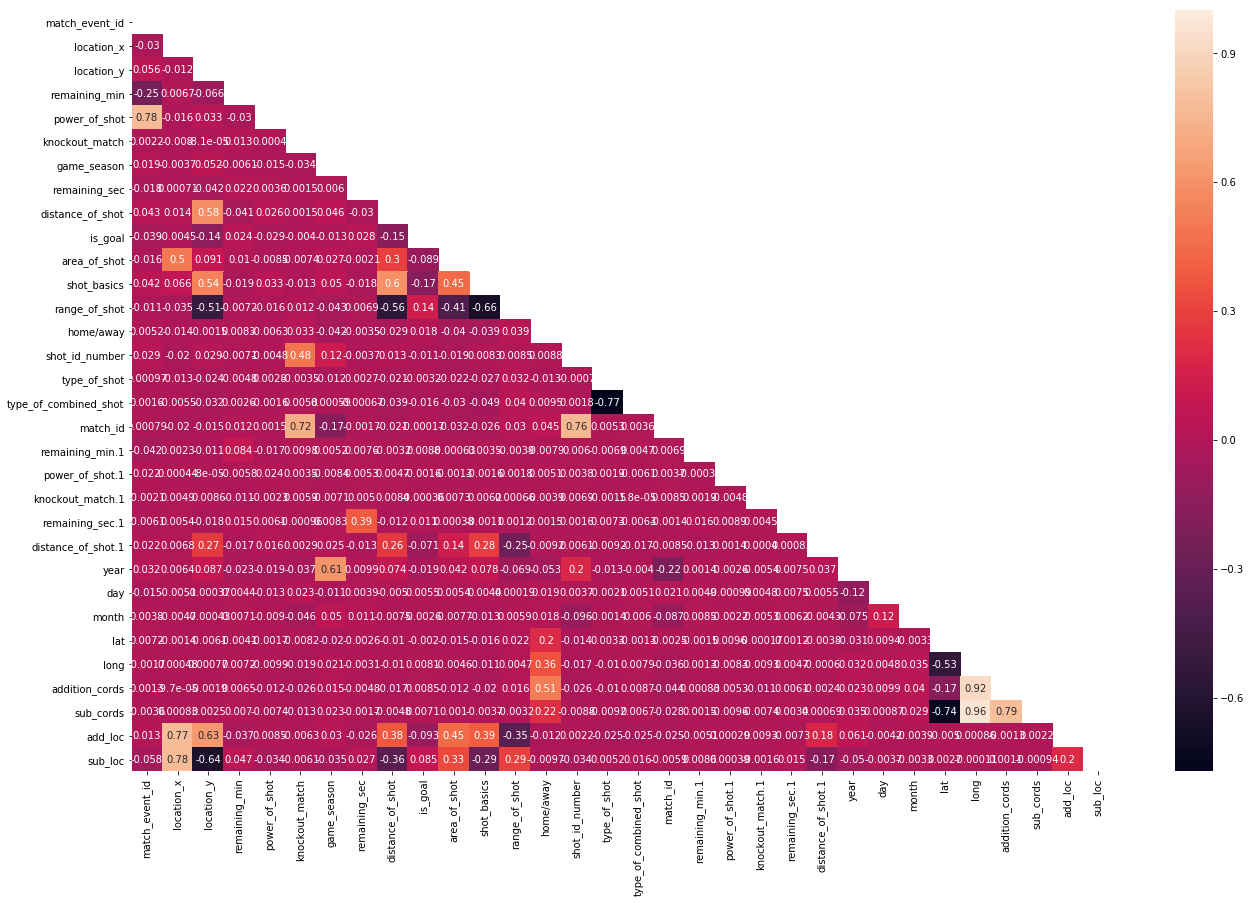

In [93]:
fig = plt.figure(figsize=(22,14))
mask = np.zeros_like(df.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(df.corr(),annot=True, mask=mask)

In [ ]:
train_df = df[df["is_goal"].notnull()].copy()
test_df = df[df["is_goal"].isnull()].copy()
print(train_df.shape, " ", test_df.shape)

In [25]:
features = [c for c in train_df.columns if c not in ['match_id', "match_event_id", 'is_goal',"shot_id_number"]]
target = train_df['is_goal']
param = {
    'bagging_freq': 5,          'bagging_fraction': 0.335,   'boost_from_average':'false',   'boost': 'gbdt',
    'feature_fraction': 0.041,   'learning_rate': 0.0083,     'max_depth': -1,                'metric':'auc',
    'min_data_in_leaf': 80,     'min_sum_hessian_in_leaf': 10.0,'num_leaves': 13,           'num_threads': 8,
    'tree_learner': 'serial',   'objective': 'binary',      'verbosity': 1
}
folds = StratifiedKFold(n_splits=5, shuffle=False, random_state=2319)
oof = np.zeros(len(train_df))
predictions = np.zeros(len(test_df))
for fold_, (trn_idx, val_idx) in enumerate(folds.split(train_df.values, target.values)):
    print("Fold {}".format(fold_))
    trn_data = lgb.Dataset(train_df.iloc[trn_idx][features], label=target.iloc[trn_idx])
    val_data = lgb.Dataset(train_df.iloc[val_idx][features], label=target.iloc[val_idx])
    clf = lgb.train(param, trn_data, 1000000, valid_sets = [trn_data, val_data], verbose_eval=5000, early_stopping_rounds = 4000)
    oof[val_idx] = clf.predict(train_df.iloc[val_idx][features], num_iteration=clf.best_iteration)
    predictions += clf.predict(test_df[features], num_iteration=clf.best_iteration) / folds.n_splits
print("CV score: {:<8.5f}".format(roc_auc_score(target, oof)))
sub = pd.DataFrame({"ID_code": test_df.ID_code.values})
sub["target"] = predictions
sub.to_csv("submission.csv", index=False)

Fold 0


ValueError: DataFrame.dtypes for data must be int, float or bool.
Did not expect the data types in fields game_season, area_of_shot, shot_basics, range_of_shot, team_name, date_of_game, home/away, lat/lng, type_of_shot, type_of_combined_shot

In [ ]:
sub = pd.DataFrame({"series_id": test['series_id'].values})
sub["surface"] = predictions[0]
for i in range(1,6):
    sub['surface'] = sub["surface"]+predictions[i]
sub['surface'] = sub["surface"]/6
sub2 = pd.DataFrame({"series_id": test_df['series_id'].values})
sub2["surface"] = predictions[2]
sub.head()
sub2.to_csv('submission39.csv', index=False)